In [35]:
from keras.preprocessing import sequence  
from keras.models import Sequential  
from keras.datasets import boston_housing  
from keras.layers import Dense, Dropout, LSTM
# from keras.utils import multi_gpu_model  
# from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
from keras import regularizers  # 正则化  

import matplotlib.pyplot as plt  
import numpy as np
from sklearn.preprocessing import MinMaxScaler  
import pandas as pd
from datetime import datetime
import quandl

In [19]:
start = date(2000,10,12)
end = date.today()
google_stock = pd.DataFrame(quandl.get("WIKI/GOOGL", start_date=start, end_date=end))
print(google_stock.shape)
# google_stock.tail()
# google_stock.head()
google_stock

(3424, 12)


,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,1092.57,1108.70,1087.21,1094.000,1990515.0,0.0,1.0,1092.570000,1108.700000,1087.210000,1094.000000,1990515.0
2018-03-22,1080.01,1083.92,1049.64,1053.150,3418154.0,0.0,1.0,1080.010000,1083.920000,1049.640000,1053.150000,3418154.0
2018-03-23,1051.37,1066.78,1024.87,1026.550,2413517.0,0.0,1.0,1051.370000,1066.780000,1024.870000,1026.550000,2413517.0


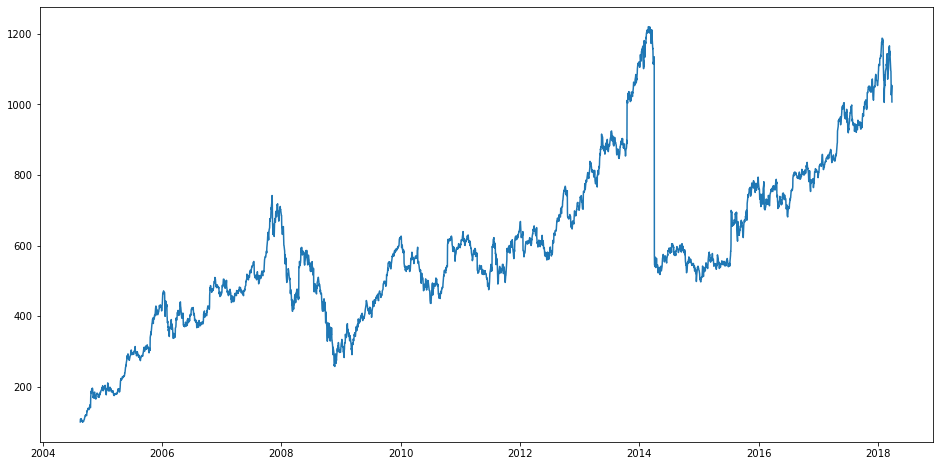

In [20]:
plt.figure(figsize=(16, 8))
plt.plot(google_stock['Close'])
plt.show()

## 构造训练集与验证集 

In [76]:
# 时间点长度
time_stamp = 50
input_stamp = 2

# 划分训练集与验证集
google_stock = google_stock[['Open', 'High', 'Low', 'Close', 'Volume']]  #  'Volume'
train = google_stock[0:2800 + time_stamp]
valid = google_stock[2800 - time_stamp:]

# 归一化
scaler = MinMaxScaler(feature_range=(0, 1))  
scaled_data = scaler.fit_transform(train)
print(scaled_data.shape)
print(scaled_data[1, 3])

# 训练集
x_train, y_train = [], []
for i in range(time_stamp, len(train)-input_stamp+1):
    x_train.append(scaled_data[i - time_stamp:i])
#     y_train.append(scaled_data[i, 3])
    y_train.append(scaled_data[i:i+input_stamp, 3])
x_train, y_train = np.array(x_train), np.array(y_train)

# 验证集
scaled_data = scaler.fit_transform(valid)
x_valid, y_valid = [], []
for i in range(time_stamp, len(valid)-input_stamp+1):
    x_valid.append(scaled_data[i - time_stamp:i])
#     y_valid.append(scaled_data[i, 3])
    y_valid.append(scaled_data[i:i+input_stamp, 3])
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)
train.head()

(2850, 5)
0.00740965576346235
(2799, 50, 5)
(623, 50, 5)
(2799, 2)
(623, 2)


,Open,High,Low,Close,Volume
Date,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0


In [77]:
# 超参数
epochs = 3
batch_size = 16
# LSTM 参数: return_sequences=True LSTM输出为一个序列。默认为False，输出一个值。
# input_dim：输入单个样本特征值的维度
# input_length：输入的时间点长度
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_dim=x_train.shape[-1], input_length=x_train.shape[1]))
model.add(LSTM(units=50))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/3
175/175 [==============================] - 6s 18ms/step - loss: 0.0049
Epoch 2/3
175/175 [==============================] - 3s 18ms/step - loss: 0.0010
Epoch 3/3
175/175 [==============================] - 3s 18ms/step - loss: 7.7226e-04


In [69]:
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(2799, 50, 5)
(623, 50, 5)
(2799, 2)
(623, 2)


In [65]:
closing_price = model.predict(x_valid)
scaler.fit_transform(pd.DataFrame(valid['Close'].values))
# 反归一化
closing_price = scaler.inverse_transform(closing_price)
y_valid = scaler.inverse_transform(y_valid)
# print(y_valid)
# print(closing_price)
# rms = np.sqrt(np.mean(np.power((y_valid - closing_price), 2)))
# print(rms)
print(closing_price.shape)
print(y_valid.shape)

20/20 [==============================] - 0s 8ms/step
289498390.3055193
(623, 2)
(623, 2)


In [86]:
print(y_valid)
print(closing_price)

[[ 656.99  671.68]
 [ 671.68  671.64]
 [ 671.64  670.  ]
 ...
 [1053.15 1026.55]
 [1026.55 1054.09]
 [1054.09 1006.94]]
[[ 655.70667  651.21356]
 [ 654.1505   649.82697]
 [ 654.67065  650.85364]
 ...
 [1140.0988  1131.4332 ]
 [1127.4801  1116.4725 ]
 [1111.6882  1098.4254 ]]


In [64]:
plt.figure(figsize=(16, 8))
dict_data = {
    'Predictions': closing_price.reshape(1,-1)[0],
    'Close': y_valid[0]
}
data_pd = pd.DataFrame(dict_data)

plt.plot(data_pd[['Close', 'Predictions']])
plt.legend(['Close', 'Predictions'], loc='upper left')  
plt.show()

ValueError: All arrays must be of the same length

<Figure size 1152x576 with 0 Axes>